In [1]:
import sklearn.datasets as ds
import pandas as pd
import numpy as np

iris_X, iris_y = ds.load_iris(return_X_y=True)
labels = ("Setosa", "Versicolor", "Virginica")

df = pd.DataFrame(iris_X, columns=["Sepal length", "Sepal width",
                                   "Petal length", "Petal width"])
df['Class'] = iris_y
df['Class'] = df['Class'].map(lambda c: labels[c])
df.head()

,Sepal length,Sepal width,Petal length,Petal width,Class
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


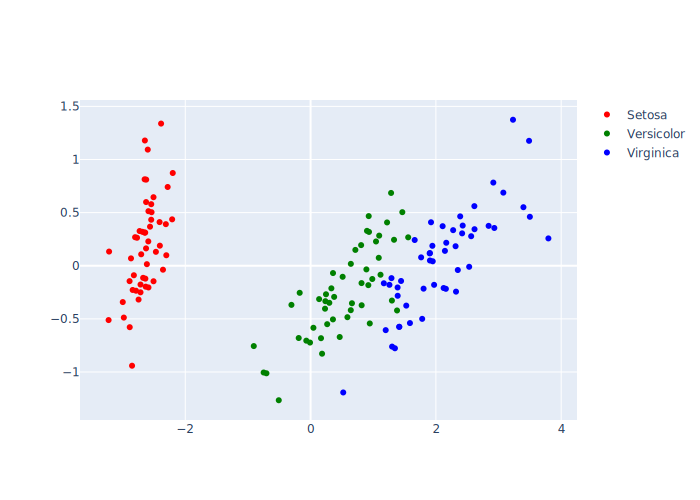

In [2]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
iris_X_2d = pca_2d.fit_transform(iris_X)

import plotly.graph_objects as go

def gr_dataset(fig): 
    for lab, col in enumerate(("red", "green", "blue")):
        fig.add_trace(go.Scatter(x=iris_X_2d[iris_y==lab, 0],
                                 y=iris_X_2d[iris_y==lab, 1],
                                 mode="markers",
                                 marker_color=col,
                                 name=labels[lab]))

fig = go.Figure()
gr_dataset(fig)
f = go.FigureWidget(fig)
f.show("svg")

In [3]:
def get_labels(x):
    mu = x.mean(axis=0)
    return np.exp(-np.linalg.norm(x - mu, axis=1))

setosa_X = iris_X_2d.copy()[iris_y==0]
versicolor_X = iris_X_2d.copy()[iris_y==1]
virginica_X = iris_X_2d.copy()[iris_y==2]

setosa_mean = setosa_X.mean(axis=0)
versicolor_mean = versicolor_X.mean(axis=0)
virginica_mean = virginica_X.mean(axis=0)

setosa_y_crisp = [1] * len(setosa_X)
setosa_y_fuzzy = get_labels(setosa_X)
setosa_X = np.vstack([setosa_X, [virginica_mean]])
setosa_y_crisp += [0]
setosa_y_fuzzy = np.hstack([setosa_y_fuzzy, [0]])

versicolor_y_crisp = [1] * len(versicolor_X)
versicolor_y_fuzzy = get_labels(versicolor_X)
versicolor_X = np.vstack([versicolor_X, [virginica_mean]])
versicolor_y_crisp += [0]
versicolor_y_fuzzy = np.hstack([versicolor_y_fuzzy, [0]])

from sklearn.preprocessing import MinMaxScaler
versicolor_y_fuzzy = MinMaxScaler().fit_transform(
    np.expand_dims(versicolor_y_fuzzy,
                   axis=1)).squeeze()

virginica_y_crisp = [1] * len(virginica_X)
virginica_y_fuzzy = get_labels(virginica_X)
virginica_X = np.vstack([virginica_X, [versicolor_mean]])
virginica_y_crisp += [0]
virginica_y_fuzzy = np.hstack([virginica_y_fuzzy, [0]])


In [4]:
def gr_membership_contour(estimated_membership, colorscale):
    fig = go.Figure()
    gr_dataset(fig)
    x = np.linspace(-4, 4, 30)
    y = np.linspace(-1.5, 1.5, 30)
    X, Y = np.meshgrid(x, y)
    zs = estimated_membership(np.array((np.ravel(X), np.ravel(Y))).T)
    Z = zs.reshape(X.shape)

    fig.add_trace(go.Contour(x=x, y=y, z=Z,
                             colorscale=colorscale,
                             line_smoothing=0.85,
                             contours={"start": 0, "end": 1, "size": .1,
                                       "showlabels": True,
                                       "labelfont": {"size": 12,
                                                     "color": "white"}
                                       },
                             showscale=False))
    go.FigureWidget(fig).show("svg")

colorscale_setosa = [[0, 'rgba(0.1, 0, 0, 0.0)'],
                     [1, 'rgba(0.9, 0, 0, 0.5)']]

colorscale_versicolor = [[0, 'rgba(0, 0.1, 0, 0.0)'],
                         [1, 'rgba(0, 0.9, 0, 0.5)']]

colorscale_virginica = [[0, 'rgba(0, 0, 0.1, 0.0)'],
                        [1, 'rgba(0, 0, 0.9, 0.5)']]

70.0-percentile is 0.01911254163582843


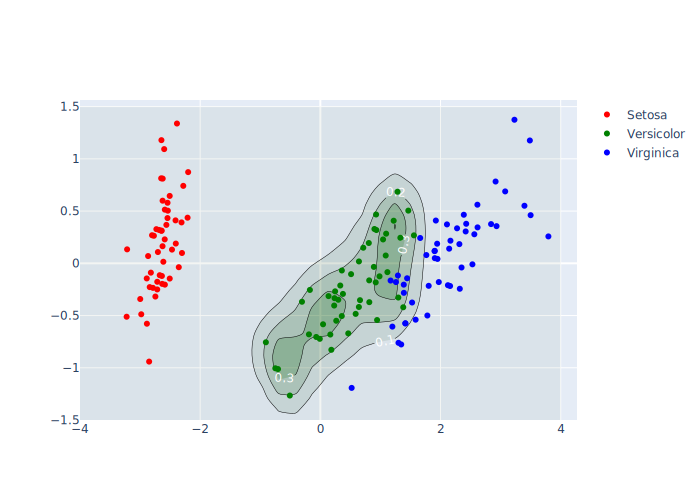

In [26]:
from mulearn import FuzzyInductor
from mulearn.kernel import GaussianKernel

fi_versicolor = FuzzyInductor(k=GaussianKernel(.4),
                             fuzzifier=ExponentialFuzzifier(profile='alpha',
                                                            alpha=.7))
fi_versicolor.fit(versicolor_X, versicolor_y_crisp)
gr_membership_contour(fi_versicolor.predict, colorscale=colorscale_versicolor)

70.0-percentile is 0.01346182271498908


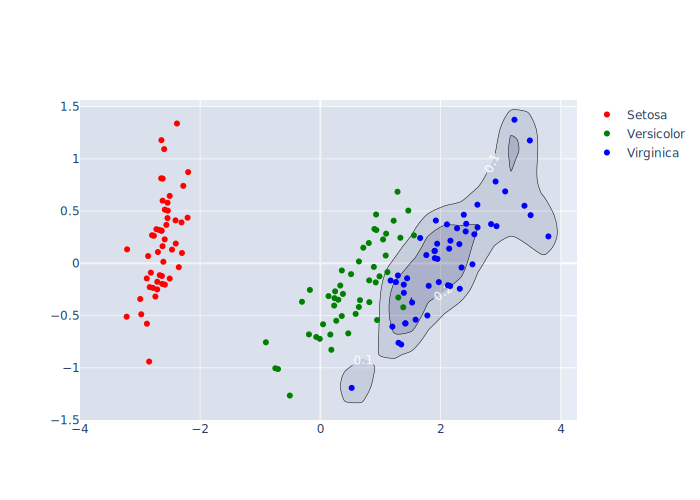

In [22]:
from mulearn.fuzzifier import ExponentialFuzzifier

fi_virginica = FuzzyInductor(k=GaussianKernel(.4),
                             fuzzifier=ExponentialFuzzifier(profile='alpha',
                                                            alpha=.7))
fi_virginica.fit(virginica_X, virginica_y_crisp)
gr_membership_contour(fi_virginica.predict, colorscale=colorscale_virginica)

70.0-percentile is 0.060283483865182286


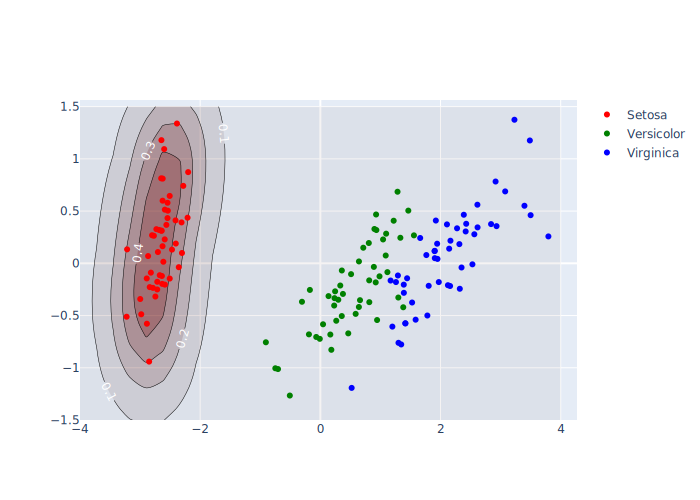

In [25]:
fi_setosa = FuzzyInductor(k=GaussianKernel(.9),
                             fuzzifier=ExponentialFuzzifier(profile='alpha',
                                                            alpha=.7))
fi_setosa.fit(setosa_X, setosa_y_crisp)
gr_membership_contour(fi_setosa.predict, colorscale=colorscale_setosa)

In [27]:
inferred = {'setosa': fi_setosa.predict,
            'versicolor': fi_versicolor.predict,
            'virginica': fi_virginica.predict}

def mu_setosa(x):
    return fi_setosa.predict(x) / sum([inferred[k](x) for k in inferred])

def mu_versicolor(x):
    return fi_versicolor.predict(x) / sum([inferred[k](x) for k in inferred])

def mu_virginica(x):
    return fi_virginica.predict(x) / sum([inferred[k](x) for k in inferred])

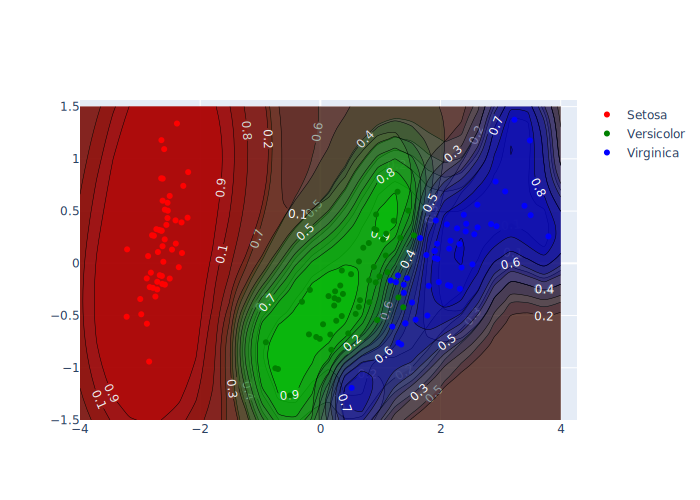

In [28]:
def all_mus(mus, colorscales):
        fig = go.Figure()
        gr_dataset(fig)

        x = np.linspace(-4, 4, 30)
        y = np.linspace(-1.5, 1.5, 30)
        X, Y = np.meshgrid(x, y)

        for mu, colorscale in zip(mus, colorscales):
                zs = mu(np.array((np.ravel(X), np.ravel(Y))).T)
                Z = zs.reshape(X.shape)

                fig.add_trace(go.Contour(x=x, y=y, z=Z,
                                        colorscale=colorscale,
                                        line_smoothing=0.85,
                                        contours={"start": 0, "end": 1, "size": .1,
                                                "showlabels": True,
                                                "labelfont": {"size": 12,
                                                                "color": "white"}
                                                },
                                        showscale=False))

        go.FigureWidget(fig).show("svg")

colorscales = [colorscale_setosa, colorscale_versicolor, colorscale_virginica]
all_mus([mu_setosa, mu_versicolor, mu_virginica], colorscales)

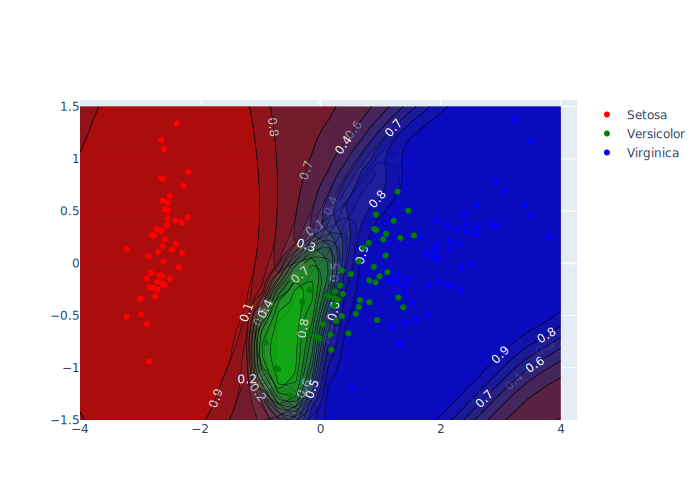

In [29]:
fi_setosa = FuzzyInductor(k=GaussianKernel(.6))
fi_setosa.fit(setosa_X, setosa_y_fuzzy)

fi_versicolor = FuzzyInductor(k=GaussianKernel(.6))
fi_versicolor.fit(versicolor_X, versicolor_y_fuzzy)

fi_virginica = FuzzyInductor(k=GaussianKernel(.6))
fi_virginica.fit(virginica_X, virginica_y_fuzzy)

inferred = {'setosa': fi_setosa.predict,
            'versicolor': fi_versicolor.predict,
            'virginica': fi_virginica.predict}

def mu_setosa(x):
    return fi_setosa.predict(x) / sum([inferred[k](x) for k in inferred])

def mu_versicolor(x):
    return fi_versicolor.predict(x) / sum([inferred[k](x) for k in inferred])

def mu_virginica(x):
    return fi_virginica.predict(x) / sum([inferred[k](x) for k in inferred])

all_mus([mu_setosa, mu_versicolor, mu_virginica], colorscales)

In [30]:
pca_1d = PCA(n_components=1)
iris_X_1d = pca_1d.fit_transform(iris_X)

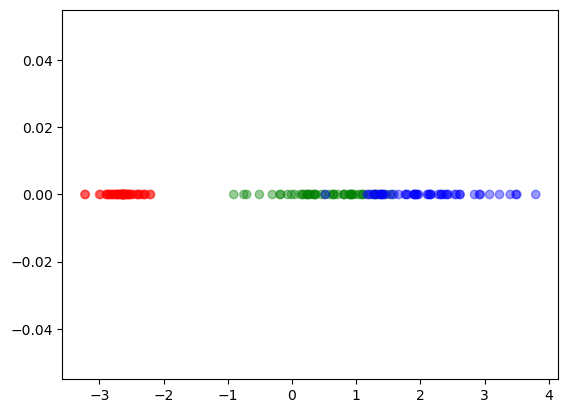

In [31]:
import matplotlib.pyplot as plt

col = {0: 'red', 1: 'green', 2: 'blue'}

plt.scatter(iris_X_1d, [0] * len(iris_X_1d),
            color=[col[c] for c in iris_y],
            alpha=.4)
plt.show()

In [43]:
setosa_X = iris_X_1d.copy()[iris_y==0]
versicolor_X = iris_X_1d.copy()[iris_y==1]
virginica_X = iris_X_1d.copy()[iris_y==2]

setosa_y_crisp = [1] * len(setosa_X)
versicolor_y_crisp = [1] * len(versicolor_X)
virginica_y_crisp = [1] * len(virginica_X)

setosa_y_fuzzy = get_labels(setosa_X)
versicolor_y_fuzzy = get_labels(versicolor_X)
virginica_y_fuzzy = get_labels(virginica_X)

setosa_X = np.vstack([setosa_X, [[-3], [-2]]])
setosa_y_crisp += [0, 0]
setosa_y_fuzzy = np.hstack([setosa_y_fuzzy, [0, 0]])

versicolor_X = np.vstack([versicolor_X, [[-2], [1.5]]])
versicolor_y_crisp += [0, 0]
versicolor_y_fuzzy = np.hstack([versicolor_y_fuzzy, [0, 0]])

virginica_X = np.vstack([virginica_X, [[0], [5]]])
virginica_y_crisp += [0, 0]
virginica_y_fuzzy = np.hstack([virginica_y_fuzzy, [0, 0]])

[7.33017055e-13]


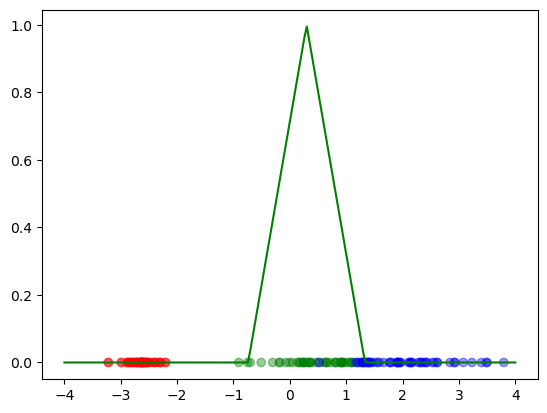

In [44]:
from mulearn.kernel import LinearKernel
from mulearn.fuzzifier import LinearFuzzifier
from mulearn import FuzzyInductor

fi_versicolor = FuzzyInductor(k=LinearKernel(),
                              fuzzifier=LinearFuzzifier(profile='triangular'))
fi_versicolor.fit(versicolor_X, versicolor_y_crisp)

x = np.linspace(-4, 4, 200)
x = np.expand_dims(x, axis=1)

plt.plot(x, fi_versicolor.predict(x), color='green')
plt.scatter(iris_X_1d, [0] * len(iris_X_1d),
            color=[col[c] for c in iris_y],
            alpha=0.4)
plt.show()

[3.1067254e-13]


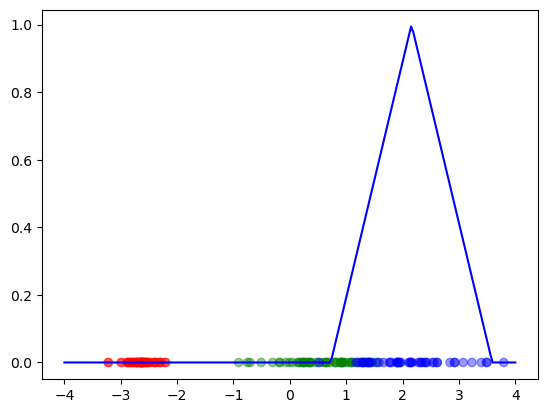

In [45]:
fi_virginica = FuzzyInductor(k=LinearKernel(),
                              fuzzifier=LinearFuzzifier(profile='triangular'))
fi_virginica.fit(virginica_X, virginica_y_crisp)

plt.plot(x, fi_virginica.predict(x), color='blue')
plt.scatter(iris_X_1d, [0] * len(iris_X_1d),
            color=[col[c] for c in iris_y],
            alpha=0.4)
plt.show()

[1.32001867e-11]


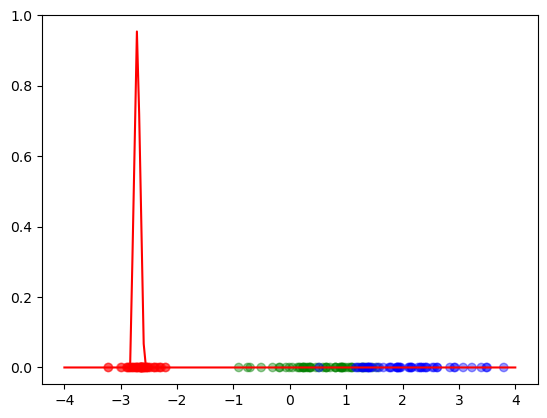

In [46]:
fi_setosa = FuzzyInductor(k=LinearKernel(),
                              fuzzifier=LinearFuzzifier(profile='triangular'))
fi_setosa.fit(setosa_X, setosa_y_crisp)

plt.plot(x, fi_setosa.predict(x), color='red')
plt.scatter(iris_X_1d, [0] * len(iris_X_1d),
            color=[col[c] for c in iris_y],
            alpha=0.4)
plt.show()

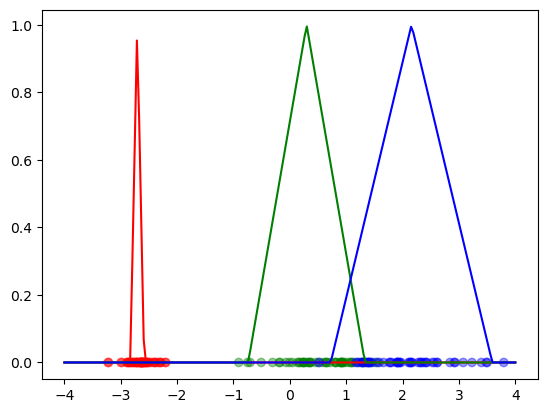

In [47]:
plt.plot(x, fi_setosa.predict(x), color='red')
plt.plot(x, fi_versicolor.predict(x), color='green')
plt.plot(x, fi_virginica.predict(x), color='blue')
plt.scatter(iris_X_1d, [0] * len(iris_X_1d),
            color=[col[c] for c in iris_y],
            alpha=0.4)
plt.show()

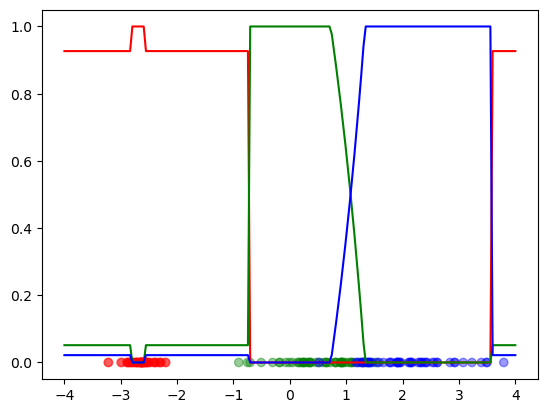

In [48]:
inferred = {'setosa': fi_setosa.predict,
            'versicolor': fi_versicolor.predict,
            'virginica': fi_virginica.predict}

def mu_setosa(x):
    return fi_setosa.predict(x) / sum([inferred[k](x) for k in inferred])

def mu_versicolor(x):
    return fi_versicolor.predict(x) / sum([inferred[k](x) for k in inferred])

def mu_virginica(x):
    return fi_virginica.predict(x) / sum([inferred[k](x) for k in inferred])

plt.plot(x, mu_setosa(x), color='red')
plt.plot(x, mu_versicolor(x), color='green')
plt.plot(x, mu_virginica(x), color='blue')
plt.scatter(iris_X_1d, [0] * len(iris_X_1d),
            color=[col[c] for c in iris_y],
            alpha=0.4)
plt.show()

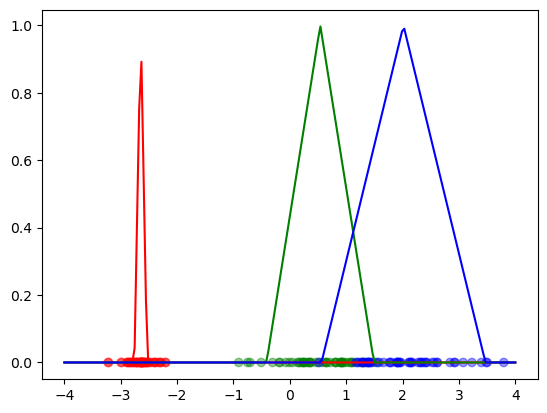

In [51]:
from mulearn.fuzzifier import LinearFuzzifier

fi_setosa = FuzzyInductor(k=LinearKernel(), fuzzifier=LinearFuzzifier())
fi_setosa.fit(setosa_X, setosa_y_fuzzy)

fi_versicolor = FuzzyInductor(k=LinearKernel(), fuzzifier=LinearFuzzifier())
fi_versicolor.fit(versicolor_X, versicolor_y_fuzzy)

fi_virginica = FuzzyInductor(k=LinearKernel(), fuzzifier=LinearFuzzifier())
fi_virginica.fit(virginica_X, virginica_y_fuzzy)

plt.plot(x, fi_setosa.predict(x), color='red')
plt.plot(x, fi_versicolor.predict(x), color='green')
plt.plot(x, fi_virginica.predict(x), color='blue')
plt.scatter(iris_X_1d, [0] * len(iris_X_1d),
            color=[col[c] for c in iris_y],
            alpha=0.4)
plt.show()

/tmp/ipykernel_728015/3059610620.py:6: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_728015/3059610620.py:9: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_728015/3059610620.py:12: RuntimeWarning:

invalid value encountered in divide



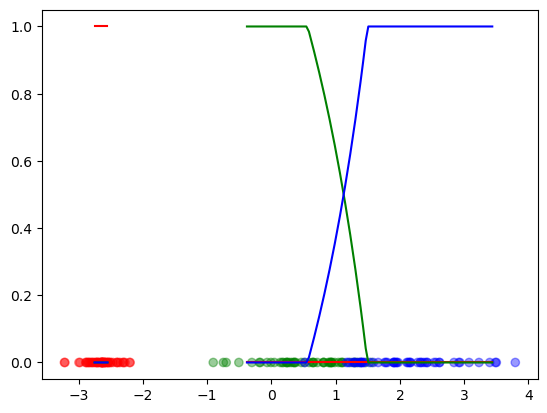

In [52]:
inferred = {'setosa': fi_setosa.predict,
            'versicolor': fi_versicolor.predict,
            'virginica': fi_virginica.predict}

def mu_setosa(x):
    return fi_setosa.predict(x) / sum([inferred[k](x) for k in inferred])

def mu_versicolor(x):
    return fi_versicolor.predict(x) / sum([inferred[k](x) for k in inferred])

def mu_virginica(x):
    return fi_virginica.predict(x) / sum([inferred[k](x) for k in inferred])

plt.plot(x, mu_setosa(x), color='red')
plt.plot(x, mu_versicolor(x), color='green')
plt.plot(x, mu_virginica(x), color='blue')
plt.scatter(iris_X_1d, [0] * len(iris_X_1d),
            color=[col[c] for c in iris_y],
            alpha=0.4)
plt.show()